## Import

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
import joblib

from utils.logistic_regression import *
from utils.helpers import *

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

PATCH_SIZE = 16

## Load the data

In [90]:
# root_training_dir = "dataset/training/"
# root_aumg_training_dir = "dataset/augmented_training/"

root_training_dir = "dataset/short_training/"
root_aumg_training_dir = "dataset/short_augmented_training/"

root_test_dir = "dataset/test_set_images/"

imgs,gt_imgs,imgs_test,n_train,image_dir,files_train = load_data(root_training_dir,root_test_dir)
augm_imgs,augm_gt_imgs,imgs_test,augm_n_train,_,_ = load_data(root_aumg_training_dir,root_test_dir)

## Extract patches from input images

In [91]:
img_patches,gt_patches = extract_patches(PATCH_SIZE,imgs,gt_imgs,n_train)
augm_img_patches,augm_gt_patches = extract_patches(PATCH_SIZE,augm_imgs,augm_gt_imgs,augm_n_train)

Shape of unflattened image patches : (2, 625, 16, 16, 3)
Shape of unflattened ground truth patches : (2, 625, 16, 16) 

Shape of flattened image patches : (1250, 16, 16, 3)
Shape of flattened ground truth patches : (1250, 16, 16) 



Shape of unflattened image patches : (5, 625, 16, 16, 3)
Shape of unflattened ground truth patches : (5, 625, 16, 16) 

Shape of flattened image patches : (3125, 16, 16, 3)
Shape of flattened ground truth patches : (3125, 16, 16) 





## Feature extraction
In order to build features for the logistic regression, we can work with different features extration methods, indeed we can extract:
- 2 features: The mean and std of grey color
- 6 features: The mean and std for the three RGB colors: 2*3=6
- 8 features: with the two previous methods

In [92]:
y = label_extraction(gt_patches)
y_augm = label_extraction(augm_gt_patches)

X2d,X6d,X8d = feature_extraction(img_patches,gt_patches)
X2d_augm,X6d_augm,X8d_augm = feature_extraction(augm_img_patches,augm_gt_patches)

Dimensions of the three different feature extraction methods (2D,6D,8D): (1250, 2),(1250, 6) and (1250, 8)

Dimensions of the three different feature extraction methods (2D,6D,8D): (3125, 2),(3125, 6) and (3125, 8)



For visualization, let's plot the distribution of road vs non-road patches (the first 1000 patchs for clarity) for the simple case of 2D features (grey mean and variance)

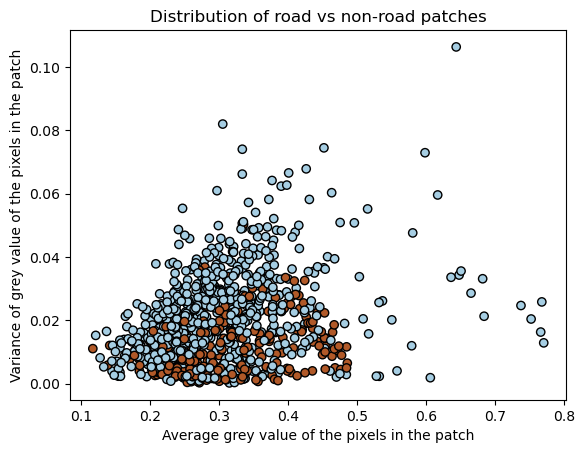

In [93]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X2d[:1000, 0], X2d[:1000, 1], c=y[:1000], edgecolors="k", cmap=plt.cm.Paired)

plt.title("Distribution of road vs non-road patches")
plt.xlabel("Average grey value of the pixels in the patch")
plt.ylabel("Variance of grey value of the pixels in the patch")
plt.show()

In [94]:
X_train_X2d, X_test_X2d, y_train_2d, y_test_2d = train_test_split(X2d, y, test_size=0.2, random_state=42)
X_train_X6d, X_test_X6d, y_train_6d, y_test_6d = train_test_split(X6d, y, test_size=0.2, random_state=42)
X_train_X8d, X_test_X8d, y_train_8d, y_test_8d = train_test_split(X8d, y, test_size=0.2, random_state=42)

X_train_X2d_augm, X_test_X2d_augm, y_train_2d_augm, y_test_2d_augm = train_test_split(X2d_augm, y_augm, test_size=0.2, random_state=42)
X_train_X6d_augm, X_test_X6d_augm, y_train_6d_augm, y_test_6d_augm = train_test_split(X6d_augm, y_augm, test_size=0.2, random_state=42)
X_train_X8d_augm, X_test_X8d_augm, y_train_8d_augm, y_test_8d_augm = train_test_split(X8d_augm, y_augm, test_size=0.2, random_state=42)

print("For the initial dataset, we have computed {} features; {} for training, and {} for validation.\n".format(len(X2d),len(X_train_X2d),len(X_test_X2d)))
print("For the augmented dataset, we have computed {} features; {} for training, and {} for validation.".format(len(X2d_augm),len(X_train_X2d_augm),len(X_test_X2d_augm)))

For the initial dataset, we have computed 1250 features; 1000 for training, and 250 for validation.

For the augmented dataset, we have computed 3125 features; 2500 for training, and 625 for validation.


In [95]:
x_train_stand_2d, x_test_stand_2d, scaler2d = standardization(X_train_X2d, X_test_X2d)
x_train_stand_6d, x_test_stand_6d, scaler6d = standardization(X_train_X6d, X_test_X6d)
x_train_stand_8d, x_test_stand_8d, scaler8d = standardization(X_train_X8d, X_test_X8d)

x_train_stand_2d_augm, x_test_stand_2d_augm, scaler2d_augm = standardization(X_train_X2d_augm, X_test_X2d_augm)
x_train_stand_6d_augm, x_test_stand_6d_augm, scaler6d_augm = standardization(X_train_X6d_augm, X_test_X6d_augm)
x_train_stand_8d_augm, x_test_stand_8d_augm, scaler8d_augm = standardization(X_train_X8d_augm, X_test_X8d_augm)

## Hyperparameter selection

In [96]:
best_model_2d, best_params_2d, best_f1_2d = optimize_logistic_regression(x_train_stand_2d, y_train_2d)
best_model_6d, best_params_6d, best_f1_6d = optimize_logistic_regression(x_train_stand_6d, y_train_6d)
best_model_8d, best_params_8d, best_f1_8d = optimize_logistic_regression(x_train_stand_8d, y_train_8d)

best_model_2d_augm, best_params_2d_augm, best_f1_2d_augm = optimize_logistic_regression(x_train_stand_2d_augm, y_train_2d_augm)
best_model_6d_augm, best_params_6d_augm, best_f1_6d_augm = optimize_logistic_regression(x_train_stand_6d_augm, y_train_6d_augm)
best_model_8d_augm, best_params_8d_augm, best_f1_8d_augm = optimize_logistic_regression(x_train_stand_8d_augm, y_train_8d_augm)

Fitting 10 folds for each of 166 candidates, totalling 1660 fits
Fitting 10 folds for each of 166 candidates, totalling 1660 fits
Fitting 10 folds for each of 166 candidates, totalling 1660 fits


c:\Users\romai\anaconda3\envs\ML_project2\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\romai\anaconda3\envs\ML_project2\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Fitting 10 folds for each of 166 candidates, totalling 1660 fits
Fitting 10 folds for each of 166 candidates, totalling 1660 fits
Fitting 10 folds for each of 166 candidates, totalling 1660 fits


c:\Users\romai\anaconda3\envs\ML_project2\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\romai\anaconda3\envs\ML_project2\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [97]:
print("For the initial data set, we have:\n")
print("For 2 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_2d,best_model_2d))
print("For 6 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_6d,best_model_6d))
print("For 8 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_8d,best_model_8d))

print("\n\n\nFor the augmented data set, we have:\n")
print("For 2 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_2d_augm,best_model_2d_augm))
print("For 6 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_6d_augm,best_model_6d_augm))
print("For 8 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_8d_augm,best_model_8d_augm))

For the initial data set, we have:

For 2 features:
 A best f1 score of 0.555768068083377 with the model: 
 LogisticRegression(C=100.0, class_weight='balanced', penalty='l1',
                   solver='liblinear')
For 6 features:
 A best f1 score of 0.554542046027251 with the model: 
 LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=0.1,
                   penalty='elasticnet', solver='saga')
For 8 features:
 A best f1 score of 0.5916133070425681 with the model: 
 LogisticRegression(class_weight='balanced', penalty='none', solver='newton-cg')



For the augmented data set, we have:

For 2 features:
 A best f1 score of 0.5496309103209904 with the model: 
 LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')
For 6 features:
 A best f1 score of 0.5450603366038786 with the model: 
 LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')
For 8 features:
 A best f1 score of 0.5880547277007381 with the model: 
 LogisticRegression(C=1000000.0, cla

In [98]:
models_dir = "./models"

# Save models
joblib.dump(best_model_2d, os.path.join(models_dir, "best_model_2d.pkl"))
joblib.dump(best_model_6d, os.path.join(models_dir, "best_model_6d.pkl"))
joblib.dump(best_model_8d, os.path.join(models_dir, "best_model_8d.pkl"))

joblib.dump(best_model_2d_augm, os.path.join(models_dir, "best_model_2d_augm.pkl"))
joblib.dump(best_model_6d_augm, os.path.join(models_dir, "best_model_6d_augm.pkl"))
joblib.dump(best_model_8d_augm, os.path.join(models_dir, "best_model_8d_augm.pkl"))

print("Models saved successfully in the /models directory.")

Models saved successfully in the /models directory.


## Evaluatation of the models

F1 scores for the initial data set:
 2 features: 0.50
 6 features: 0.50
 8 features: 0.58


F1 scores for the augmented data set:
 2 features: 0.56
 6 features: 0.57
 8 features: 0.60




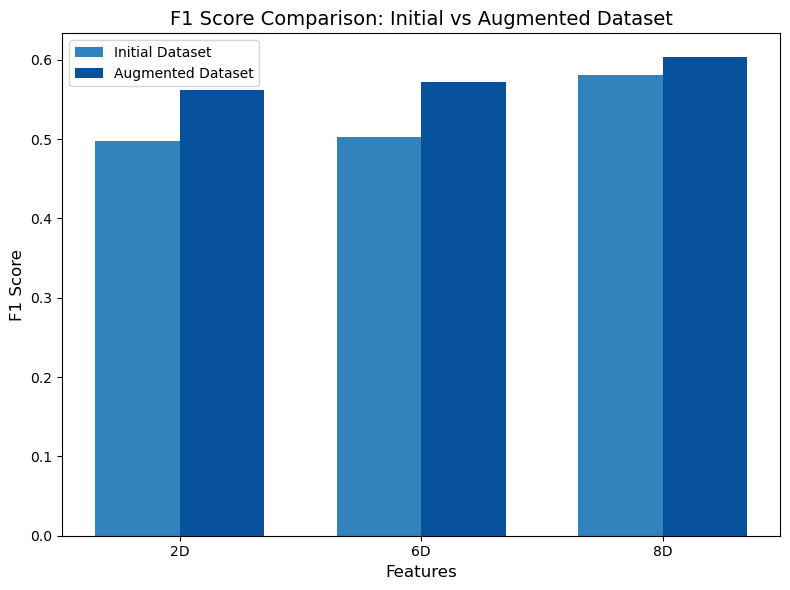

In [99]:
# Calculate F1 scores
Z2d = best_model_2d.predict(x_test_stand_2d)
Z6d = best_model_6d.predict(x_test_stand_6d)
Z8d = best_model_8d.predict(x_test_stand_8d)

Z2d_augm = best_model_2d_augm.predict(x_test_stand_2d_augm)
Z6d_augm = best_model_6d_augm.predict(x_test_stand_6d_augm)
Z8d_augm = best_model_8d_augm.predict(x_test_stand_8d_augm)

F1_2 = f1_score(y_test_2d, Z2d)
F1_6 = f1_score(y_test_6d, Z6d)
F1_8 = f1_score(y_test_8d, Z8d)

F1_2_augm = f1_score(y_test_2d_augm, Z2d_augm)
F1_6_augm = f1_score(y_test_6d_augm, Z6d_augm)
F1_8_augm = f1_score(y_test_8d_augm, Z8d_augm)

# Print F1 scores
print("F1 scores for the initial data set:")
print(" 2 features: {:.2f}".format(F1_2))
print(" 6 features: {:.2f}".format(F1_6))
print(" 8 features: {:.2f}".format(F1_8))
print("\n")

print("F1 scores for the augmented data set:")
print(" 2 features: {:.2f}".format(F1_2_augm))
print(" 6 features: {:.2f}".format(F1_6_augm))
print(" 8 features: {:.2f}".format(F1_8_augm))
print("\n")

f1_initial = [F1_2, F1_6, F1_8]
f1_augmented = [F1_2_augm, F1_6_augm, F1_8_augm]

features = ['2D', '6D', '8D']

bar_width = 0.35
x = np.arange(len(features))
# Plot
plt.figure(figsize=(8, 6))
plt.bar(x, f1_initial, width=bar_width, color="#3182bd",label='Initial Dataset')
plt.bar(x + bar_width, f1_augmented, color="#08519c",width=bar_width, label='Augmented Dataset')

# Adding labels and title
plt.xlabel('Features', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score Comparison: Initial vs Augmented Dataset', fontsize=14)
plt.xticks(x + bar_width / 2, features)
plt.legend()

# Display plot
plt.tight_layout()
plt.show()

## Visualization of the 6 models for one specific image

In [100]:
img_idx = 1

Xi2d = extract_img_features_2d(image_dir + files_train[img_idx])
Xi6d = extract_img_features(image_dir + files_train[img_idx])
Xi8d = np.concatenate((Xi2d, Xi6d), axis=1)


Xi2d = scaler2d.transform(Xi2d)
Xi6d = scaler6d.transform(Xi6d)
Xi8d = scaler8d.transform(Xi8d)  

Xi2d_augm = scaler2d_augm.transform(Xi2d)
Xi6d_augm = scaler6d_augm.transform(Xi6d)
Xi8d_augm = scaler8d_augm.transform(Xi8d)

Zi2d = best_model_2d.predict(Xi2d)
Zi6d = best_model_6d.predict(Xi6d)
Zi8d = best_model_8d.predict(Xi8d)

Zi2d_augm = best_model_2d_augm.predict(Xi2d)
Zi6d_augm = best_model_6d_augm.predict(Xi6d)
Zi8d_augm = best_model_8d_augm.predict(Xi8d)

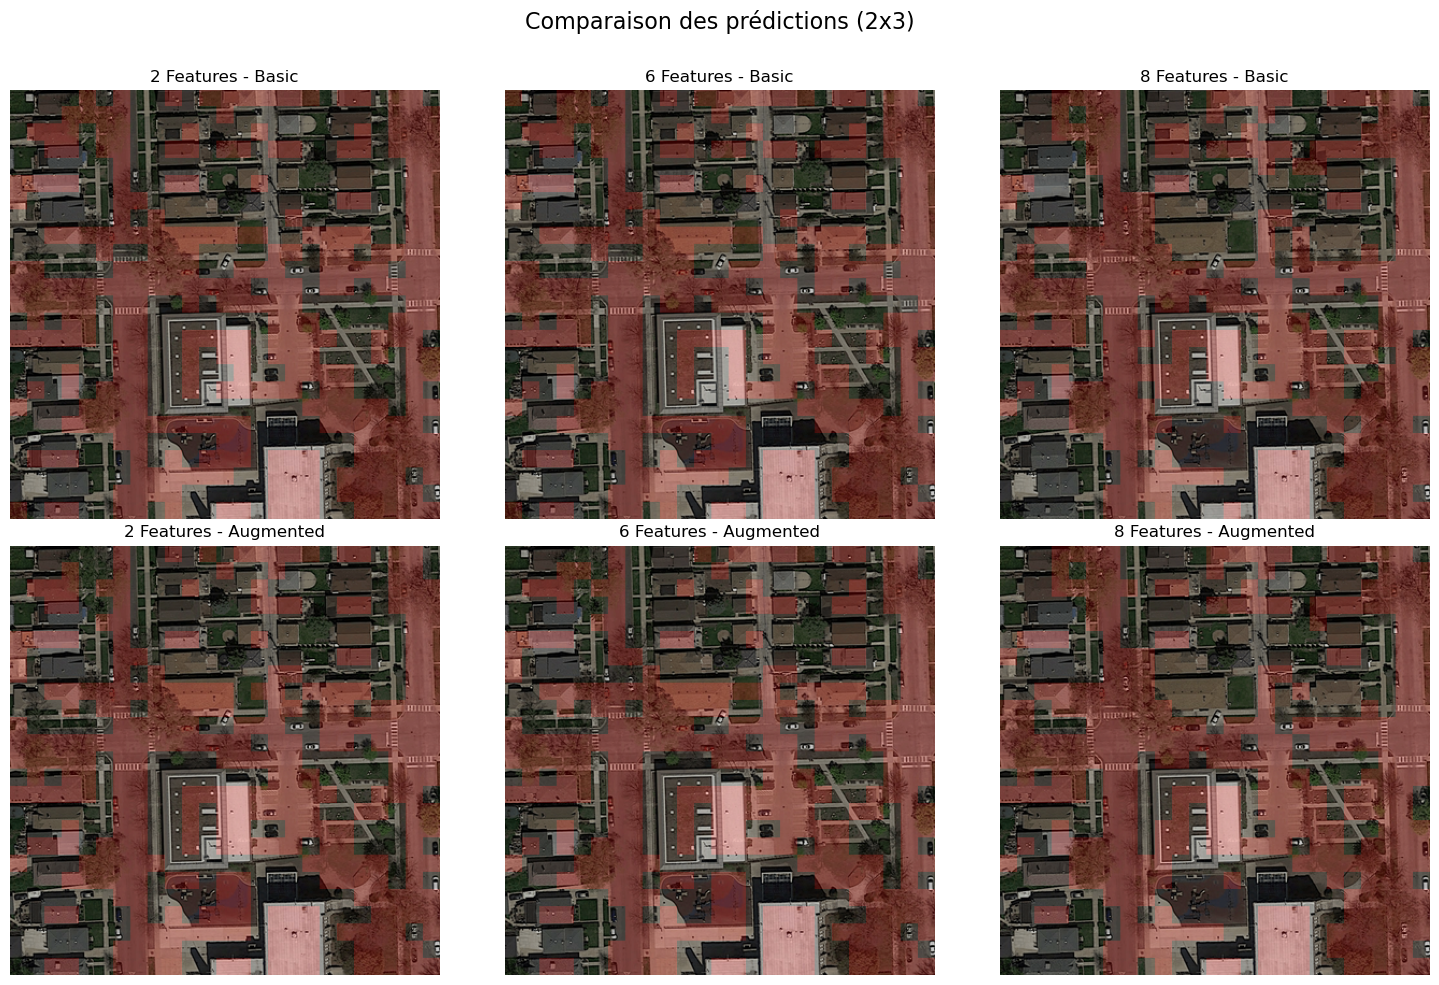

In [101]:
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Comparaison des prédictions (2x3)", fontsize=16)

titles = [
    "2 Features - Basic",
    "6 Features - Basic",
    "8 Features - Basic",
    "2 Features - Augmented",
    "6 Features - Augmented",
    "8 Features - Augmented"
]
data = [Zi2d, Zi6d, Zi8d, Zi2d_augm, Zi6d_augm, Zi8d_augm]

for i, ax in enumerate(axes.ravel()):
    predicted_im = label_to_img(w, h, PATCH_SIZE, PATCH_SIZE, data[i])
    cimg = concatenate_images(imgs[img_idx], predicted_im)
    new_img = make_img_overlay(imgs[img_idx], predicted_im)
    
    ax.imshow(new_img, cmap="Greys_r")
    ax.set_title(titles[i])
    ax.axis("off")  

plt.tight_layout()
plt.subplots_adjust(top=0.9)  
plt.show()


## Predictions

In [102]:
root_test_dir = "dataset/test_set_images/"
folder_test = os.listdir(root_test_dir)
n_test = len(folder_test)
imgs_test = [ load_image(os.path.join(root_test_dir, folder_test[i], f"{folder_test[i]}.png")) for i in range(n_test)]
imgs_test_arrays = [np.array(img) / 255 for img in imgs_test]

img_test_patches = [img_crop(imgs_test[i], PATCH_SIZE, PATCH_SIZE) for i in range(n_test)]


# Convert to numpy arrays
img_test_patches = np.array(img_test_patches)

print(f"Shape of unflattened image test patches : {img_test_patches.shape}\n")

# Linearize list of patches
img_test_patches = np.asarray(
    [
        img_test_patches[i][j]
        for i in range(len(img_test_patches))
        for j in range(len(img_test_patches[i]))
    ]
)

print(f"Shape of flattened test image patches : {img_test_patches.shape}\n")


X2d_test = np.asarray([extract_features_2d(img_test_patches[i]) for i in range(len(img_test_patches))])
X6d_test = np.asarray([extract_features(img_test_patches[i]) for i in range(len(img_test_patches))])
X8d_test = np.asarray([np.concatenate((X2d_test[i], X6d_test[i])) for i in range(len(X2d_test))])
print(X2d_test.shape,X6d_test.shape,X8d_test.shape)

X2d_test_scaled = scaler2d.transform(X2d_test)
X6d_test_scaled = scaler6d.transform(X6d_test)
X8d_test_scaled = scaler8d.transform(X8d_test)

Xi2d_augm_scaled = scaler2d_augm.transform(X2d_test)
Xi6d_augm_scaled = scaler6d_augm.transform(X6d_test)
Xi8d_augm_scaled = scaler8d_augm.transform(X8d_test)

Z2d_test_prediction = best_model_2d.predict(X2d_test_scaled)
Z6d_test_prediction = best_model_6d.predict(X6d_test_scaled)
Z8d_test_prediction = best_model_8d.predict(X8d_test_scaled)

Z2d_augm_test_prediction = best_model_2d_augm.predict(Xi2d_augm_scaled)
Z6d_augm_test_prediction = best_model_6d_augm.predict(Xi6d_augm_scaled)
Z8d_augm_test_prediction = best_model_8d_augm.predict(Xi8d_augm_scaled)

# create submission files

w_test, h_test = imgs_test_arrays[0].shape[:2]
sqrt_n_patches = w_test // PATCH_SIZE

array_to_submission('predictions2d.csv', Z2d_test_prediction, sqrt_n_patches, PATCH_SIZE)
array_to_submission('predictions6d.csv', Z6d_test_prediction, sqrt_n_patches, PATCH_SIZE)
array_to_submission('predictions8d.csv', Z8d_test_prediction, sqrt_n_patches, PATCH_SIZE)

array_to_submission('predictions2d_augmented.csv', Z2d_augm_test_prediction, sqrt_n_patches, PATCH_SIZE)
array_to_submission('predictions6d_augmented.csv', Z6d_augm_test_prediction, sqrt_n_patches, PATCH_SIZE)
array_to_submission('predictions8d_augmented.csv', Z8d_augm_test_prediction, sqrt_n_patches, PATCH_SIZE)

Shape of unflattened image test patches : (50, 1444, 16, 16, 3)

Shape of flattened test image patches : (72200, 16, 16, 3)

(72200, 2) (72200, 6) (72200, 8)
